# [NetworkX](https://networkx.github.io/) Tutorial 3

In this tutorial, we will introduce a new Python library that provides several network diffusion algorithms.

[Network Diffusion Library (NDlib)](https://ndlib.readthedocs.io/en/latest/) is a package that implements some diffusion models for simulating and analyzing diffusion processes on networks. Its tutorial can be found [here](https://ndlib.readthedocs.io/en/latest/tutorial.html). It can be easily downloaded with `pip`:

```python
>>> !pip install ndlib
```


In [1]:
try:
    import ndlib
except:
    !pip install ndlib

## <font color='red'>Attention</font>
    
This assignment requires networkx-2.5. To figure out your networkx version, 
```python
import networkx as nx
nx.__version__
```
If the NetworkX version is 2.4 or less, we can upgrade it to the latest version by running
```bash
!pip install --upgrade networkx
```

In [2]:
nx_version = !python -c "import networkx;print(networkx.__version__)"
if float(nx_version[0]) < 2.5:
    !pip install --upgrade networkx
import networkx as nx
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc
import matplotlib.pyplot as plt
%matplotlib inline

nx.__version__

'2.5'

First, as usual, let's create a dummy graph for demonstration and visualize its structure.

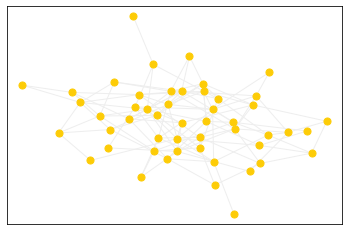

In [3]:
G = nx.dense_gnm_random_graph(50, 120, seed=42)
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos=pos, with_labels=False, node_color='#FDCC07', 
                 edge_color='#eeeeee', node_size=50)

## Model selection
NDlib provides a list of epidemic models which can be found [here](https://ndlib.readthedocs.io/en/latest/reference/reference.html#epidemics). For example, let's create a SI model:

In [4]:
model = ep.SIModel(G)

### SI model
SI models only involve two states: "susceptible" and "infected". The statuses are interpreted as: 

|Name	|Code
|---    |--- 
|Susceptible|0
|Infected	|1

The infected parameter is defined by `beta` in this model:

|Name|Type|Value Type|Description|
|---|--- |--- |--- |
|beta|Model|float in [0, 1]|Infection probability|


## Model configuration
NDlib uses configuration objects to define model parameters. Let's create a configuration object and define the `beta` parameter.

In [5]:
cfg = mc.Configuration()
cfg.add_model_parameter('beta', 0.5)

To start a diffusion, we need to have a set of seed nodes. There are two ways to add seed nodes to our configuration. We can either specify the seed nodes or define the fraction of nodes to be set as seed nodes.

To select specific seed nodes, we use the method
```python
config = mc.Configuration()
config.add_model_initial_configuration("Infected", seed_node_set)
```

To define a range of infected nodes, we use the method
```python
config = mc.Configuration()
config.add_model_parameter("fraction_infected", ratio_of_infection)
```

For example, let's select the first 5 nodes in the graph as seed nodes and add them to our configuration:

In [6]:
seed_nodes = list(G.nodes)[:5]
print("Selected seed nodes:", seed_nodes)
cfg.add_model_initial_configuration("Infected", seed_nodes)

Selected seed nodes: [0, 1, 2, 3, 4]


Now let's use this configuration for the SI model we previously created.

In [7]:
model.set_initial_status(cfg)

Now we are all set with the model configuration, we can start a simulation. We do this by using the `iteration_bunch(number_of_iteration)` method. For example, let's run 10 iterations:

In [8]:
iterations = model.iteration_bunch(10)

This method returns a list of dictionaries which contain information for each iteration:
- `iteration`: specify which round of iteration it is
- `status`: a dictionary of (node: status), specifies the node statuses in the current round. Status equals 1 if infected and 0 if not.
- `node_count`: the sum of nodes that are infected or not infected.
- `status_delta`: the change in the number of nodes for each status.

For example, let's take a look at the change of nodes after the first iteration:

In [9]:
iterations[1]

{'iteration': 1,
 'status': {10: 1, 21: 1, 32: 1, 34: 1, 39: 1, 47: 1, 48: 1},
 'node_count': {0: 38, 1: 12},
 'status_delta': {0: -7, 1: 7}}

We can plot and visualize the results across iterations. Here we'll use red to indicate infected nodes.

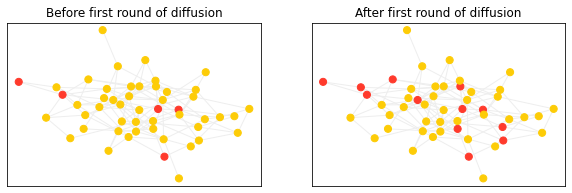

In [10]:
color_list = ['#FDCC07', '#FF3A2C']
fig, axes = plt.subplots(1, 2, figsize=[10,3])
node_list_before = [color_list[v] for _, v in iterations[0]['status'].items()]
nx.draw_networkx(G, pos=pos, with_labels=False, node_color=node_list_before, 
                 edge_color='#eeeeee', node_size=50, ax=axes[0])
axes[0].set_title("Before first round of diffusion")

for k, v in iterations[1]['status'].items():
    node_list_before[k] = color_list[v]
nx.draw_networkx(G, pos=pos, with_labels=False, node_color=node_list_before, 
                 edge_color='#eeeeee', node_size=50, ax=axes[1])
axes[1].set_title("After first round of diffusion");

### SIR model

[SIR model](https://ndlib.readthedocs.io/en/latest/reference/models/epidemics/SIR.html) has one more state than the SI model:

|Name	|Code
|---|---
|Susceptible	|0
|Infected	|1
|Removed	|2

And in addition to `beta`, it has an additional `gamma` parameter which indicates the probability of removing a node.

Let's explore a SIR model. This time, let's define the inital state using a fraction of infected nodes.

In [11]:
model = ep.SIRModel(G)

cfg = mc.Configuration()
cfg.add_model_parameter('beta', 0.5)
cfg.add_model_parameter('gamma', 0.2)
cfg.add_model_parameter("fraction_infected", 0.1)
model.set_initial_status(cfg)

iterations = model.iteration_bunch(10)

Let's look at the the first iteration.

In [12]:
iterations[1]

{'iteration': 1,
 'status': {1: 1,
  6: 1,
  7: 1,
  16: 1,
  30: 1,
  40: 1,
  42: 1,
  43: 1,
  44: 1,
  47: 1,
  48: 1},
 'node_count': {0: 34, 1: 16, 2: 0},
 'status_delta': {0: -11, 1: 11, 2: 0}}

Similarly, we can visualize the diffusion process. We'll use blue to represent the recovered status. Let's compare the initial status with the status after 5 iterations.

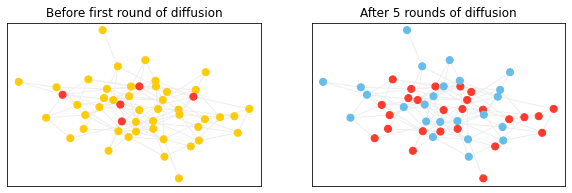

In [13]:
color_list = ['#FDCC07', '#FF3A2C', '#66BDE9']
fig, axes = plt.subplots(1, 2, figsize=[10,3])
node_list_before = [color_list[v] for _, v in iterations[0]['status'].items()]
nx.draw_networkx(G, pos=pos, with_labels=False, node_color=node_list_before, 
                 edge_color='#eeeeee', node_size=50, ax=axes[0])
axes[0].set_title("Before first round of diffusion")

for i in range(1, 6):
    for k, v in iterations[i]['status'].items():
        node_list_before[k] = color_list[v]
nx.draw_networkx(G, pos=pos, with_labels=False, node_color=node_list_before, 
                 edge_color='#eeeeee', node_size=50, ax=axes[1])
axes[1].set_title("After 5 rounds of diffusion");

### SIS model

[SIS model](https://ndlib.readthedocs.io/en/latest/reference/models/epidemics/SIS.html) has a susceptible state, where a node can become infected with probability beta. After a node becomes infected, it can switch back to susceptible with probability lambda. The only allowed transitions are S -> I -> S.

|Name	|Code
|---|---
|Susceptible	|0
|Infected	|1

Of course, the parameters, `beta` and `lambda` set the probabilities for transitioning to the infected and  susceptible statuses, respectively.

Now that we have practiced with the SI model and SIR model, we can easily simulate a diffusion with the SIS model:

In [14]:
model = ep.SISModel(G)

cfg = mc.Configuration()
cfg.add_model_parameter('beta', 0.5)
cfg.add_model_parameter('lambda', 0.2)
cfg.add_model_parameter("fraction_infected", 0.1)
model.set_initial_status(cfg)

iterations = model.iteration_bunch(10)
iterations[-1]

{'iteration': 9,
 'status': {0: 0,
  4: 1,
  6: 1,
  7: 0,
  13: 1,
  15: 0,
  16: 0,
  20: 0,
  23: 0,
  26: 0,
  34: 1,
  37: 1,
  42: 0,
  49: 0},
 'node_count': {0: 11, 1: 39},
 'status_delta': {0: 4, 1: -4}}



### Threshold model

In addition to the SI families, NDlib also implements other diffusion models such as the [threshold model](https://ndlib.readthedocs.io/en/latest/reference/models/epidemics/Threshold.html):

```python
ndlib.models.epidemics.ThresholdModel.ThresholdModel(graph, seed=None)
```

We can configure a threshold model by defining a `threshold` parameter **for each node in the graph**. For example, let all nodes have threshold 0.25:

In [15]:
model = ep.ThresholdModel(G)
    
cfg = mc.Configuration()
cfg.add_model_initial_configuration("Infected", seed_nodes)

for i in G.nodes:
    cfg.add_node_configuration("threshold", i, 0.25)
model.set_initial_status(cfg)

iterations = model.iteration_bunch(10)

Let's view snapshots of the diffusion process after iterations 3 and 6:

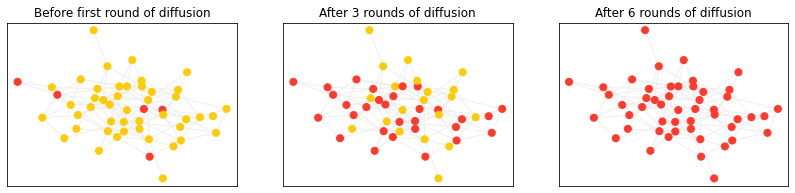

In [16]:
color_list = ['#FDCC07', '#FF3A2C']
fig, axes = plt.subplots(1, 3, figsize=[14,3])
node_list_before = [color_list[v] for _, v in iterations[0]['status'].items()]
nx.draw_networkx(G, pos=pos, with_labels=False, node_color=node_list_before, 
                 edge_color='#eeeeee', node_size=50, ax=axes[0])
axes[0].set_title("Before first round of diffusion")

for i in range(1, 4):
    for k, v in iterations[i]['status'].items():
        node_list_before[k] = color_list[v]
nx.draw_networkx(G, pos=pos, with_labels=False, node_color=node_list_before, 
                 edge_color='#eeeeee', node_size=50, ax=axes[1])
axes[1].set_title("After 3 rounds of diffusion");

for i in range(4, 7):
    for k, v in iterations[i]['status'].items():
        node_list_before[k] = color_list[v]
nx.draw_networkx(G, pos=pos, with_labels=False, node_color=node_list_before, 
                 edge_color='#eeeeee', node_size=50, ax=axes[2])
axes[2].set_title("After 6 rounds of diffusion");

### Independent cascade model

The [independent cascade model](https://ndlib.readthedocs.io/en/latest/reference/models/epidemics/IndependentCascades.html) also has a threshold parameter. Note, however, that this threshold is not the same as the threshold of the threshold model. Here it is **specified for edges and represents the probability of diffusion along each edge**.

Nodes in an IC model will be in one of 3 status:

|Name	|Code|
|-|-|
Susceptible|	0
Infected|	1
Removed|	2

Let's define a IC model with every edge threshold 0.5:

In [17]:
model = ep.IndependentCascadesModel(G)

cfg.add_model_parameter("fraction_infected", 0.1)
for e in G.edges():
    cfg.add_edge_configuration("threshold", e, 0.5)
model.set_initial_status(cfg)

iterations = model.iteration_bunch(10)

Let's view the snapshots of diffusion process after 3 and 6 rounds of iteration:

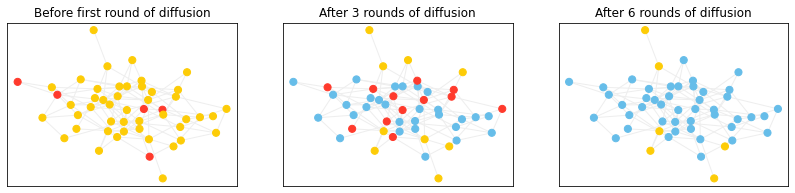

In [18]:
color_list = ['#FDCC07', '#FF3A2C','#66BDE9']
fig, axes = plt.subplots(1, 3, figsize=[14,3])
node_list_before = [color_list[v] for _, v in iterations[0]['status'].items()]
nx.draw_networkx(G, pos=pos, with_labels=False, node_color=node_list_before, 
                 edge_color='#eeeeee', node_size=50, ax=axes[0])
axes[0].set_title("Before first round of diffusion")

for i in range(1, 4):
    for k, v in iterations[i]['status'].items():
        node_list_before[k] = color_list[v]
nx.draw_networkx(G, pos=pos, with_labels=False, node_color=node_list_before, 
                 edge_color='#eeeeee', node_size=50, ax=axes[1])
axes[1].set_title("After 3 rounds of diffusion");

for i in range(4, 7):
    for k, v in iterations[i]['status'].items():
        node_list_before[k] = color_list[v]
nx.draw_networkx(G, pos=pos, with_labels=False, node_color=node_list_before, 
                 edge_color='#eeeeee', node_size=50, ax=axes[2])
axes[2].set_title("After 6 rounds of diffusion");

# End